In [6]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
pd.set_option('display.max_columns', None)

In [ ]:
def concat_all_leagues():
    # data from football-data.co.uk
    
    country_files = Path('data/football-data/').glob('*.csv')
    df_list = [pd.read_csv(f) for f in country_files]
    
    df = pd.concat(df_list, ignore_index=True)
    df = df[['Country', 'League', 'Season', 'Date', 'Home', 'Away', 'HG', 'AG', 'Res', 'PSCH', 'PSCD', 'PSCA']]
    print(f'Total matches loaded: {df.shape[0]}')
    df.rename(columns={'PSCH': 'HomeOdds', 'PSCD': 'DrawOdds', 'PSCA': 'AwayOdds'}, inplace=True)
    df.dropna(how='any', inplace=True)
    print(f'Total matches loaded: {df.shape[0]}')

    df.to_excel('data/football-data/new_leagues_concat.xlsx', index=False)

# concat_all_leagues()

In [9]:
country = 'POL'

In [10]:
# orig_df = pd.read_csv(f'data/football-data/{country}.csv')
orig_df = pd.read_excel(f'data/football-data/new_leagues_concat.xlsx')

In [11]:
orig_df['Season'] = orig_df['Season'].astype(str)
orig_df['Date'] = pd.to_datetime(orig_df['Date'], format='%d/%m/%Y')
orig_df.sort_values(by=['Date'], inplace=True)
orig_df.reset_index(drop=True, inplace=True)

In [12]:
orig_df.head()

,Country,League,Season,Date,Home,Away,HG,AG,Res,HomeOdds,DrawOdds,AwayOdds
0,Ireland,Premier Division,2012,2012-03-02,Drogheda,Shamrock Rovers,1,2,A,11.63,5.16,1.34
1,Ireland,Premier Division,2012,2012-03-02,St. Patricks,Bray,1,0,H,1.54,4.21,7.34
2,Ireland,Premier Division,2012,2012-03-02,UC Dublin,Cork City,1,0,H,4.47,3.65,1.89
3,Ireland,Premier Division,2012,2012-03-02,Monaghan,Dundalk,0,0,D,2.78,3.10,2.92
4,Ireland,Premier Division,2012,2012-03-02,Shelbourne,Sligo Rovers,1,1,D,4.01,3.26,2.13


In [13]:
orig_df.shape

(56088, 12)

In [14]:
for col in ['BFECH', 'BFECD', 'BFECA', 'B365CH', 'B365CD', 'B36CA']:
    if col in orig_df.columns:
        orig_df.drop(columns=[col], inplace=True)
        
orig_df.rename(columns={'PSCH': 'HomeOdds', 'PSCD': 'DrawOdds', 'PSCA': 'AwayOdds'}, inplace=True)

In [15]:
try:
    orig_df['ImpliedPProbH'] = orig_df.apply(lambda row: 1/row['HomeOdds'] / (1/row['HomeOdds'] + 1/row['DrawOdds'] + 1/row['AwayOdds']), axis=1)
    orig_df['ImpliedPProbD'] = orig_df.apply(lambda row: 1/row['DrawOdds'] / (1/row['HomeOdds'] + 1/row['DrawOdds'] + 1/row['AwayOdds']), axis=1)
    orig_df['ImpliedPProbA'] = orig_df.apply(lambda row: 1/row['AwayOdds'] / (1/row['HomeOdds'] + 1/row['DrawOdds'] + 1/row['AwayOdds']), axis=1)
    orig_df['PBookieSpread'] = orig_df.apply(lambda row: 1/row['HomeOdds'] + 1/row['DrawOdds'] + 1/row['AwayOdds'] - 1, axis=1)
    print(float(round(orig_df['PBookieSpread'].mean() * 100, 4)))
except KeyError:
    pass

3.1494


In [16]:
def strategy_flat_underdogs(row):
    bet_size = 1
    result = None
    
    threshold = 4

    if row['HomeOdds'] >= threshold:
        if row['Res'] == 'H':
            result = row['HomeOdds'] - 1
        else:
            result = -1
    elif row['AwayOdds'] >= threshold:
        if row['Res'] == 'A':
            result = row['AwayOdds'] - 1
        else:
            result = -1

    if result is not None:
        return result, bet_size
    else:
        return None, None

In [17]:
def strategy_dynamic_underdogs(row, min_odds_threshold=4, max_odds_threshold=100):
    bet_size = 1
    result = None

    max_odds = max(row['HomeOdds'], row['AwayOdds'])

    if max_odds >= min_odds_threshold and max_odds <= max_odds_threshold:
        bet_size = min_odds_threshold / max_odds
        if row['HomeOdds'] == max_odds and row['Res'] == 'H':
            result = bet_size * (row['HomeOdds'] - 1)
            # if threshold == 10 and max_odds >= 10:
            #     print(row[['Season', 'Date', 'Home', 'Away', 'HG', 'AG', 'Res', 'HomeOdds', 'AwayOdds']].tolist())
        elif row['AwayOdds'] == max_odds and row['Res'] == 'A':
            result = bet_size * (row['AwayOdds'] - 1)
            # if threshold == 10 and max_odds >= 10:
            #     print(row[['Season', 'Date', 'Home', 'Away', 'HG', 'AG', 'Res', 'HomeOdds', 'AwayOdds']].tolist())
        else:
            result = -bet_size
    
    if result is not None:
        return result, bet_size
    else:
        return None, None

In [18]:
def strategy_flat_favourites(row):
    bet_size = 1
    result = None
    threshold = 2

    if row['HomeOdds'] <= threshold:
        if row['Res'] == 'H':
            result = row['HomeOdds'] - 1
        else:
            result = -1
    elif row['AwayOdds'] <= threshold:
        if row['Res'] == 'A':
            result = row['AwayOdds'] - 1
        else:
            result = -1

    if result is not None:
        return result, bet_size
    else:
        return None, None

In [19]:
def strategy_dynamic_favourites(row):
    bet_size = 1
    result = None
    
    threshold = 2

    min_odds = min(row['HomeOdds'], row['AwayOdds'])
    if min_odds <= threshold:
        bet_size = 1 / min_odds
        if row['HomeOdds'] == min_odds and row['Res'] == 'H':
            result = bet_size * (row['HomeOdds'] - 1)
        elif row['AwayOdds'] == min_odds and row['Res'] == 'A':
            result = bet_size * (row['AwayOdds'] - 1)
        else:
            result = -bet_size
            
    if result is not None:
        return result, bet_size
    else:
        return None, None

In [20]:
def strategy_flat_always_home(row):
    bet_size = 1
    result = None

    if row['Res'] == 'H':
        result = row['HomeOdds'] - 1
    else:
        result = -1

    if result is not None:
        return result, bet_size
    else:
        return None, None

In [21]:
def strategy_dynamic_always_home(row):
    bet_size = 1 / row['HomeOdds']
    result = None

    if row['Res'] == 'H':
        result = bet_size * (row['HomeOdds'] - 1)
    else:
        result = -bet_size

    if result is not None:
        return result, bet_size
    else:
        return None, None

In [22]:
def strategy_flat_always_draw(row):
    bet_size = 1
    result = None

    if row['Res'] == 'D':
        result = row['DrawOdds'] - 1
    else:
        result = -1

    if result is not None:
        return result, bet_size
    else:
        return None, None

In [23]:
# seasons = ['2022/2023', '2023/2024', '2024/2025', '2025/2026']

In [24]:
# df = orig_df[orig_df['Season'] >= '2020'].copy()
df = orig_df.copy()

Strategy: strategy_flat_underdogs
Number of bets: 26823
ROI: -8.04%
Strategy: strategy_dynamic_underdogs_thr4
Number of bets: 26823
Returns: -1388.17
Sum of bet sizes: 19204.17
ROI: -7.23%
Strategy: strategy_dynamic_underdogs_thr7
Number of bets: 6446
Returns: -368.82
Sum of bet sizes: 4869.82
ROI: -7.57%
Strategy: strategy_dynamic_underdogs_thr10
Number of bets: 2182
Returns: -339.45
Sum of bet sizes: 1679.45
ROI: -20.21%
Strategy: strategy_flat_favourites
Number of bets: 26429
ROI: -1.33%
Strategy: strategy_dynamic_favourites
Number of bets: 26429
ROI: -1.37%
Strategy: strategy_flat_always_home
Number of bets: 56088
ROI: -2.73%
Strategy: strategy_dynamic_always_home
Number of bets: 56088
ROI: -2.32%
Strategy: strategy_flat_always_draw
Number of bets: 56088
ROI: -3.42%


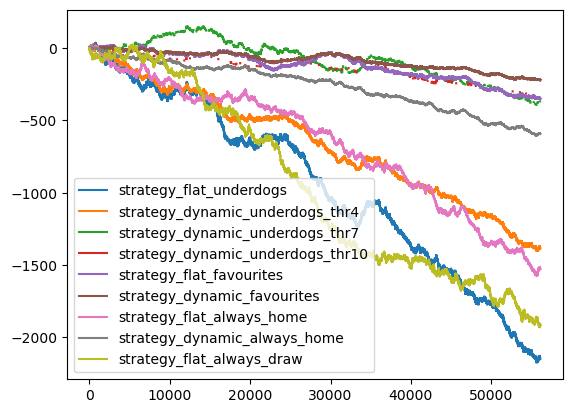

In [25]:
strategies = [strategy_flat_underdogs, strategy_dynamic_underdogs, strategy_flat_favourites, strategy_dynamic_favourites, strategy_flat_always_home, strategy_dynamic_always_home, strategy_flat_always_draw]

for strategy in strategies:
    strategy_name = strategy.__name__
    strategy_betsize = f'{strategy_name}_bet_size'

    if strategy_name == 'strategy_dynamic_underdogs':
        for threshold in [4, 7, 10]:
            strategy_name_thresh = f'{strategy_name}_thr{threshold}'
            strategy_betsize_thresh = f'{strategy_name_thresh}_bet_size'
            df[strategy_name_thresh] = df.apply(lambda row: strategy(row, min_odds_threshold=threshold)[0], axis=1)
            df[strategy_name_thresh].cumsum().plot(kind='line')
            df[strategy_betsize_thresh] = df.apply(lambda row: strategy(row, min_odds_threshold=threshold)[1], axis=1)
                
            print(f'Strategy: {strategy_name_thresh}')
            print(f'Number of bets: {df[strategy_betsize_thresh].count()}')
            print(f'Returns: {round(df[strategy_name_thresh].sum(), 2)}')
            print(f'Sum of bet sizes: {round(df[strategy_betsize_thresh].sum(), 2)}')

            roi = f'{round(df[strategy_name_thresh].sum() / df[strategy_betsize_thresh].sum() * 100, 2)}%'

            print(f'ROI: {roi}')
    else:
        df[strategy_name] = df.apply(lambda row: strategy(row)[0], axis=1)
        df[strategy_name].cumsum().plot()
        df[strategy_betsize] = df.apply(lambda row: strategy(row)[1], axis=1)

        print(f'Strategy: {strategy_name}')
        print(f'Number of bets: {df[strategy_betsize].count()}')
        # print(f'Returns: {round(df[strategy_name].sum(), 2)}')

        roi = f'{round(df[strategy_name].sum() / df[strategy_betsize].sum() * 100, 2)}%'

        print(f'ROI: {roi}')

plt.legend(loc='lower left')
plt.show()

Threshold: 3.0 | Number of bets: 32537 | Returns: -1263.33 | ROI: -4.79%
Threshold: 3.5 | Number of bets: 23433 | Returns: -1342.08 | ROI: -6.91%
Threshold: 4.0 | Number of bets: 16987 | Returns: -990.38 | ROI: -6.92%
Threshold: 4.5 | Number of bets: 12788 | Returns: -505.38 | ROI: -4.62%
Threshold: 5.0 | Number of bets: 9665 | Returns: -552.02 | ROI: -6.57%
Threshold: 5.5 | Number of bets: 7232 | Returns: -425.85 | ROI: -6.71%
Threshold: 6.0 | Number of bets: 5540 | Returns: -177.31 | ROI: -3.62%
Threshold: 6.5 | Number of bets: 4275 | Returns: -319.13 | ROI: -8.39%
Threshold: 7.0 | Number of bets: 3459 | Returns: -59.27 | ROI: -1.91%
Threshold: 7.5 | Number of bets: 2789 | Returns: -236.28 | ROI: -9.39%
Threshold: 8.0 | Number of bets: 2194 | Returns: -290.73 | ROI: -14.58%
Threshold: 8.5 | Number of bets: 1779 | Returns: -189.37 | ROI: -11.65%
Threshold: 9.0 | Number of bets: 1431 | Returns: -130.07 | ROI: -9.94%
Threshold: 9.5 | Number of bets: 1165 | Returns: -3.95 | ROI: -0.37%
T

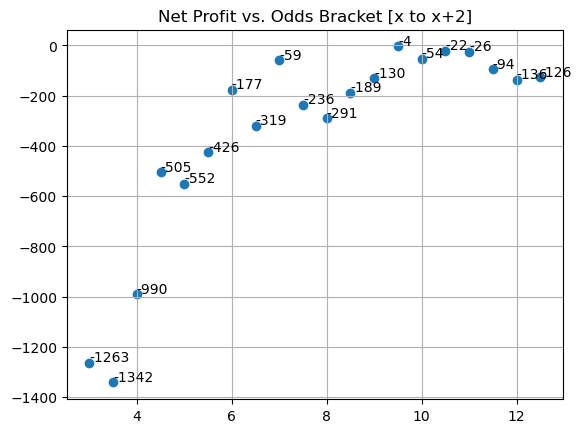

In [26]:
strategy = strategy_dynamic_underdogs

strategy_name = strategy.__name__
strategy_betsize = f'{strategy_name}_bet_size'

results = []

for threshold in np.arange(3, 13, 0.5):
    strategy_name_thresh = f'{strategy_name}_thr{threshold}'
    strategy_betsize_thresh = f'{strategy_name_thresh}_bet_size'
    df[strategy_name_thresh] = df.apply(lambda row: strategy(row, min_odds_threshold=threshold, max_odds_threshold=threshold+2)[0], axis=1)
    df[strategy_betsize_thresh] = df.apply(lambda row: strategy(row, min_odds_threshold=threshold, max_odds_threshold=threshold+2)[1], axis=1)

    number_of_bets = df[strategy_betsize_thresh].count()
    net_profit = round(df[strategy_name_thresh].sum(), 2)
    roi = round(df[strategy_name_thresh].sum() / df[strategy_betsize_thresh].sum() * 100, 2)
    print(f'Threshold: {threshold} | Number of bets: {number_of_bets} | Returns: {net_profit} | ROI: {roi}%')

    results.append((threshold, net_profit, roi))

offset = 5

plt.figure()
plt.grid(True)
plt.scatter([r[0] for r in results], [r[1] for r in results])

for r in results:
    plt.text(r[0], r[1] + offset, f'{int(round(r[1]))}')

plt.title('Net Profit vs. Odds Bracket [x to x+2]')
plt.show()

Threshold: 3.0 | Number of bets: 32537 | Returns: -1263.33 | ROI: -4.79%
Threshold: 3.5 | Number of bets: 23433 | Returns: -1342.08 | ROI: -6.91%
Threshold: 4.0 | Number of bets: 16987 | Returns: -990.38 | ROI: -6.92%
Threshold: 4.5 | Number of bets: 12788 | Returns: -505.38 | ROI: -4.62%
Threshold: 5.0 | Number of bets: 9665 | Returns: -552.02 | ROI: -6.57%
Threshold: 5.5 | Number of bets: 7232 | Returns: -425.85 | ROI: -6.71%
Threshold: 6.0 | Number of bets: 5540 | Returns: -177.31 | ROI: -3.62%
Threshold: 6.5 | Number of bets: 4275 | Returns: -319.13 | ROI: -8.39%
Threshold: 7.0 | Number of bets: 3459 | Returns: -59.27 | ROI: -1.91%
Threshold: 7.5 | Number of bets: 2789 | Returns: -236.28 | ROI: -9.39%
Threshold: 8.0 | Number of bets: 2194 | Returns: -290.73 | ROI: -14.58%
Threshold: 8.5 | Number of bets: 1779 | Returns: -189.37 | ROI: -11.65%
Threshold: 9.0 | Number of bets: 1431 | Returns: -130.07 | ROI: -9.94%
Threshold: 9.5 | Number of bets: 1165 | Returns: -3.95 | ROI: -0.37%
T

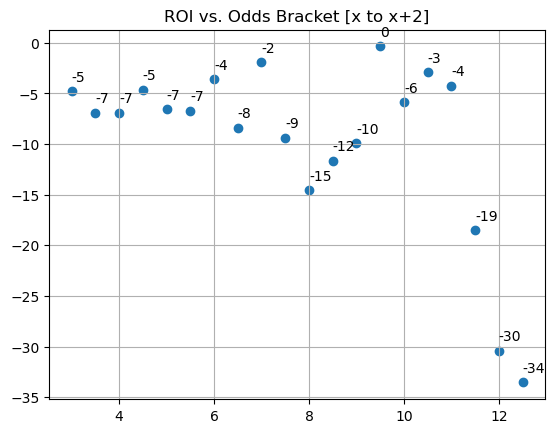

In [27]:
strategy = strategy_dynamic_underdogs

strategy_name = strategy.__name__
strategy_betsize = f'{strategy_name}_bet_size'

results = []

for threshold in np.arange(3, 13, 0.5):
    strategy_name_thresh = f'{strategy_name}_thr{threshold}'
    strategy_betsize_thresh = f'{strategy_name_thresh}_bet_size'
    df[strategy_name_thresh] = df.apply(lambda row: strategy(row, min_odds_threshold=threshold, max_odds_threshold=threshold+2)[0], axis=1)
    df[strategy_betsize_thresh] = df.apply(lambda row: strategy(row, min_odds_threshold=threshold, max_odds_threshold=threshold+2)[1], axis=1)

    number_of_bets = df[strategy_betsize_thresh].count()
    net_profit = round(df[strategy_name_thresh].sum(), 2)
    roi = round(df[strategy_name_thresh].sum() / df[strategy_betsize_thresh].sum() * 100, 2)
    print(f'Threshold: {threshold} | Number of bets: {number_of_bets} | Returns: {net_profit} | ROI: {roi}%')

    results.append((threshold, net_profit, roi))

offset = 1

plt.figure()
plt.grid(True)
plt.scatter([r[0] for r in results], [r[2] for r in results])

for r in results:
    plt.text(r[0], r[2] + offset, f'{int(round(r[2]))}')

plt.title('ROI vs. Odds Bracket [x to x+2]')
plt.show()